In [3]:
import pandas as pd
import gzip
import json
from pathlib import Path
import tqdm
from collections import defaultdict
import matplotlib_venn
import matplotlib.pyplot as plt

raf_path = Path('../2-9.playwright/output/raf/')
imr = Path('./imr')

imr.mkdir(parents=True, exist_ok=True)

def deal(path):
    try:
        with gzip.open(path, 'rt') as fp:
            ret = json.load(fp)
    except Exception as e:
        print(path)
        raise e
    ret['raf_path'] = path.as_posix()
    idx = path.as_posix().split('/')[-1].split('.')[0]
    try:
        ret['idx'] = int(idx)
    except ValueError:
        ret['idx'] = idx
    return ret

In [4]:
# 0413 + 0504_czy = 0504-df_label
df_label = pd.read_pickle('./output/0501-df_label-raf.pkl.zst.bak', compression='zstd')
df_label

,url,category,label_ERROR,label_usecase,label_interactions,label_comments
0,http://0ldsk00l.ca/,['bq'],0,1,0,
1,http://1000.chromeexperiments.com,[awwwards],0,1,1,
2,http://1000000-lives.com/,['bq'],0,3,0,
3,http://10k.global/,['bq'],0,1,1,
4,http://123screenprotector.com/,['bq'],0,3,0,
...,...,...,...,...,...,...
29237,https://map.e-mangistau.kz/,['bq'],1,<NA>,<NA>,<NA>
29238,https://map.e-zhetisu.kz/,['bq'],0,1,1,
29239,https://map.iturkistan.kz/,['bq'],1,<NA>,<NA>,<NA>
29240,https://qrg.geoportal.kz/,['bq'],1,<NA>,<NA>,<NA>


In [5]:
df_label['label_comments'].value_counts()

label_comments
                      26031
scroll                  675
TODO                    504
domain                  246
waiting                  88
TODO (URL error)         38
File not found           38
white                     8
404                       3
Webdriver Error           1
you have no offers        1
Name: count, dtype: Int64

In [6]:
df_label2 = pd.read_pickle('./input/2023-05-09_0-30000_output.pkl').rename(columns={
    'error': 'label_ERROR',
    'comments': 'label_comments',
    'use_case': 'label_usecase',
    'need_interactions': 'label_interactions',
})
df_label2.value_counts()

label_ERROR  label_usecase  label_interactions  label_comments
0.0          1              0                                     14098
                            1                                       831
                                                waiting             206
                            0                   scroll              101
             4              0                                        34
             2              1                                        24
Name: count, dtype: int64

In [7]:
df_label.update(df_label2)
df_label['category'] = df_label['category'].map(lambda x: x if type(x) == list else eval(x))
df_label.loc[df_label['label_comments'] =='domain', 'label_ERROR'] = 4

In [8]:
import re

def url_essential(url: str):
    re_pattern = r'^(http(s)?://)?(.*?)(/?index(\.[a-z]+)?)?[#/]*$'
    return re.match(re_pattern, url).group(3)

In [11]:
tmp = df_label.copy()
tmp['url_essential'] = df_label['url'].map(url_essential)
tmp.drop_duplicates(subset=['url_essential'], inplace=True)
tmp.drop(columns=['url_essential'], inplace=True)
tmp['label_ERROR'].value_counts().drop(0).sum()

2660

In [16]:
with open('output/0518-df_label-raf-need_interactions.json', 'w') as fp:
    json.dump([['{:05d}'.format(idx), x['url']] for idx, x in df_label[(df_label['label_interactions']==1)|(df_label['label_comments']=='TODO')].iterrows()], fp)

In [17]:
df_label['label_ERROR'].value_counts()

label_ERROR
0    26034
1     2161
4      247
3      187
2       81
Name: count, dtype: Int64

In [19]:
tmp4 = tmp['category']
tmp1 = tmp4.explode()
tmp1.value_counts()

category
bq              20906
awwwards         4097
tranco           3489
cssdesign        1326
threejs           150
tfjs_gallery       82
googleart          37
custom             10
david              10
Name: count, dtype: int64

In [22]:
translate = {
    'bq': 'HTTP Archive',
    'awwwards': 'Crawling/Galleries',
    'tranco': 'Crawling/Top list',
    'cssdesign': 'Crawling/Galleries',
    'threejs': 'Crawling/Galleries',
    'tfjs_gallery': 'Crawling/Galleries',
    'googleart': 'Crawling/Galleries',
    'custom': 'Crawling/Galleries',
    'david': 'Crawling/Galleries',
}
tmp2 = tmp4.map(lambda x: sorted(set([translate[y] for y in x])))
tmp2.value_counts()

category
[HTTP Archive]                        20779
[Crawling/Galleries]                   4663
[Crawling/Top list]                    3485
[Crawling/Galleries, HTTP Archive]      123
[]                                       37
[Crawling/Top list, HTTP Archive]         4
Name: count, dtype: int64

## HERE DATASOURCE COLLECTED!

In [23]:
tmp2e = tmp2.explode()
tmp2e.value_counts()

category
HTTP Archive          20906
Crawling/Galleries     4786
Crawling/Top list      3489
Name: count, dtype: int64

In [12]:
tmp.shape

(29091, 6)

In [14]:
tmp2e = tmp[tmp['label_ERROR'] == 0]
tmp2e['label_interactions'].value_counts()

label_interactions
0    24081
1     1820
Name: count, dtype: Int64

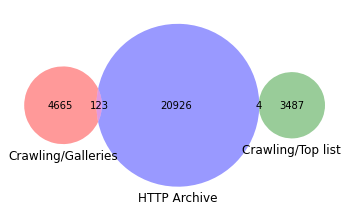

In [12]:
matplotlib_venn.venn3([set(tmp2e[tmp2e == 'Crawling/Galleries'].index), set(tmp2e[tmp2e == 'Crawling/Top list'].index), set(tmp2e[tmp2e == 'HTTP Archive'].index)], set_labels=['Crawling/Galleries', 'Crawling/Top list', 'HTTP Archive'])
plt.savefig('fig/results_overview_coll_venn.pdf', bbox_inches='tight')

## RAF

In [14]:
if Path('imr/0504-df_raw_all-raf.pkl.zst').exists():
    df = pd.read_pickle('imr/0504-df_raw_all-raf.pkl.zst', compression='zstd')
else:
    df = pd.DataFrame([deal(p) for p in sorted(raf_path.glob("*.gz"))]).set_index('idx')
    df = df_label.drop(columns=['url']).join(df)
    # df.drop(df['url'].map(url_essential).duplicated().index, inplace=True)
    df['url_essential'] = df['url'].map(url_essential)
    df.drop_duplicates(subset=['url_essential'], inplace=True)
    df.to_pickle('imr/0504-df_raw_all-raf.pkl.zst', compression='zstd')

In [15]:
def ttt(x):
    try:
        return any([y['value']['data']['usedWebGL'] for y in x])
    except:
        return False

In [16]:
tmp = df[df['label_interactions'] == 1]
tmp['Used WebGL'] = tmp['frame'].str['gl_raf_counters'].map(ttt)
tmp.drop(columns=['frame','events_time_hp','raf_path']).to_csv('A.csv')

/tmp/ipykernel_2761187/3932600663.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp['Used WebGL'] = tmp['frame'].str['gl_raf_counters'].map(ttt)


In [17]:
if Path('imr/0504-df_frame-raf.pkl.zst').exists():
    df_frame = pd.read_pickle('imr/0504-df_frame-raf.pkl.zst', compression='zstd')
else:
    df.dropna(subset=['frame'], inplace=True)
    df_frame = df.drop(columns=['frame', 'events_time_hp']).join(pd.DataFrame(df['frame'].to_list(), index=df.index)['gl_rafs'].explode()).reset_index(drop=False).rename(columns={'index': 'idx'})
    df_frame = df_frame.drop(columns=['gl_rafs']).join(pd.DataFrame(df_frame['gl_rafs'].str['value'].to_list(), index=df_frame.index)['data'])
    df_frame = df_frame.drop(columns=['data']).join(pd.json_normalize(df_frame['data']).add_prefix('frame.'), how='right').dropna(subset=['frame.counter.usedWebGL']) #.drop_duplicates(subset=['frame.url']).reset_index(drop=True)
    df_frame.to_pickle('imr/0504-df_frame-raf.pkl.zst', compression='zstd')

In [18]:
if Path('imr/0504-df_context-raf.pkl.zst').exists():
    df_context = pd.read_pickle('imr/0504-df_context-raf.pkl.zst', compression='zstd')
else:
    df_context = df_frame.explode('frame.contextInfo').reset_index(drop=False).rename(columns={'index': 'idx-frame'})
    df_context = df_context.drop(columns=['frame.contextInfo']).join(
        pd.json_normalize(df_context['frame.contextInfo']).add_prefix('frame.context.'))
    df_context.to_pickle('imr/0504-df_context-raf.pkl.zst', compression='zstd')

In [19]:
if Path('imr/0504-df_context-noraf.pkl.zst').exists():
    df_context_noraf = pd.read_pickle('imr/0504-df_context-noraf.pkl.zst', compression='zstd')
else:
    df_context_noraf = df_context.drop(columns=['frame.context.rafList'])
    df_context_noraf.to_pickle('imr/0504-df_context-noraf.pkl.zst', compression='zstd')

In [20]:
if Path('imr/0504-df_shader-noraf.pkl.zst').exists():
    df_shader = pd.read_pickle('imr/0504-df_shader-noraf.pkl.zst', compression='zstd')
else:
    df_shader = df_context_noraf[['idx-frame','idx','category','label_ERROR','label_usecase','label_interactions','label_comments','url','date','raf_path','frame.url','frame.title','frame.date','frame.when','frame.context.maghsk.shaders',]].explode('frame.context.maghsk.shaders').dropna(subset=['frame.context.maghsk.shaders']).reset_index(drop=False).rename(columns={'index': 'idx-context'})
    df_shader = df_shader.drop(columns='frame.context.maghsk.shaders').join(pd.json_normalize(df_shader['frame.context.maghsk.shaders']).add_prefix('frame.context.maghsk.shaders.')).dropna(subset=['frame.context.maghsk.shaders.source'])
    df_shader = df_shader.explode('frame.context.maghsk.shaders.source').dropna(subset=['frame.context.maghsk.shaders.source'])
    df_shader['frame.context.maghsk.shaders.type'] = df_shader['frame.context.maghsk.shaders.type'].astype(str).replace('35632', 'frag').replace('35633', 'vert')
    df_shader['frame.context.maghsk.shaders.length'] = df_shader['frame.context.maghsk.shaders.source'].map(lambda x: len(x))
    df_shader.to_pickle('imr/0504-df_shader-noraf.pkl.zst', compression='zstd')

In [21]:
df_shader.columns

Index(['idx-context', 'idx-frame', 'idx', 'category', 'label_ERROR',
       'label_usecase', 'label_interactions', 'label_comments', 'url', 'date',
       'raf_path', 'frame.url', 'frame.title', 'frame.date', 'frame.when',
       'frame.context.maghsk.shaders.id',
       'frame.context.maghsk.shaders.compiled',
       'frame.context.maghsk.shaders.source',
       'frame.context.maghsk.shaders.translatedSource',
       'frame.context.maghsk.shaders.type',
       'frame.context.maghsk.shaders.length'],
      dtype='object')

## Spector

In [22]:
import base64
import json
import tqdm
import pandas as pd
from pathlib import Path
import gzip


In [23]:
spec_path = Path('../2-9.playwright/output/spector-one/')

In [24]:
def spector_deal(p):
    ret = json.loads(p.read_text())
    ret['spec_path'] = p.as_posix()
    frame = []
    for spector in ret['spector']:
        try:
            frame.append({"url": spector['value']['url'], "data": [base64.b64decode(x[22:]) for x in spector['value']['data']]})
        except:
            pass
    del ret['spector']
    ret['frame'] = frame
    return ret

In [25]:
if Path('imr/0504-df_spector.pkl.zst').exists():
    df = pd.read_pickle('imr/0504-df_spector.pkl.zst', compression='zstd')
else:
    df = pd.DataFrame([spector_deal(p) for p in tqdm.tqdm(sorted(spec_path.glob("*.json")))]).set_index('idx')
    df = df.explode('frame').dropna(subset=['frame']).reset_index(drop=False).rename(columns={'index': 'idx'})
    df = df.drop(columns='frame').join(pd.json_normalize(df['frame']).add_prefix('frame.')).explode('frame.data').dropna(subset='frame.data').reset_index(drop=False).rename(columns={'index': 'idx-frame'})
    df['frame.data'] = df['frame.data'].map(lambda x: json.loads(gzip.decompress(x)))
    df.to_pickle('imr/0504-df_spector.pkl.zst', compression='zstd')

100%|██████████| 29242/29242 [01:09<00:00, 422.54it/s] 


## Simple

In [26]:
simple_path = Path('../2-9.playwright/output/simple/')

In [27]:
def deal_simple(p):
    with gzip.open(p, 'rt') as f:
        return json.load(f)

In [28]:
if Path('imr/0504-df_simple.pkl.zst').exists():
    df = pd.read_pickle('imr/0504-df_simple.pkl.zst', compression='zstd')
else:
    df_raw = pd.DataFrame([deal_simple(p) for p in tqdm.tqdm(sorted(simple_path.glob("*.gz")))])
    df = df_raw.drop(columns=['frame', 'events_time_hp']).join(pd.json_normalize(df_raw['frame']).drop(columns=['net_idle_counters','gl_simple_counters'])).explode('gl_simples').dropna(subset='gl_simples').reset_index(drop=False).rename(columns={'index': 'idx'})
    df = df.drop(columns='gl_simples').join(pd.json_normalize(df['gl_simples'].str['value']).drop(columns=['data', 'error.name']).add_prefix('frame.')).explode('frame.data.contextInfo').dropna(subset=['frame.data.contextInfo']).reset_index(drop=False).rename(columns={'index': 'idx-frame'})
    df = df.drop(columns=['frame.data.contextInfo']).join(pd.json_normalize(df['frame.data.contextInfo']).add_prefix('frame.data.contextInfo.'))
    df.to_pickle('imr/0504-df_simple.pkl.zst', compression='zstd')

100%|██████████| 29241/29241 [00:07<00:00, 4077.05it/s]


## Worker

In [29]:
import gzip
import json
from pathlib import Path
import pandas as pd

In [30]:
def deal_worker(p):
    with gzip.open(p, 'rt') as f:
        return json.load(f)

In [31]:
worker_path = Path('../2-9.playwright/output/worker/')

In [32]:
if Path('imr/df_worker_oc.pkl.zst').exists() and Path('imr/df_frame_oc.pkl.zst').exists():
    df_worker_oc = pd.read_pickle("imr/df_worker_oc.pkl.zst", compression='zstd')
    df_frame_oc = pd.read_pickle("imr/df_frame_oc.pkl.zst", compression='zstd')
else:
    df_raw = pd.DataFrame([deal_worker(p) for p in sorted(worker_path.glob("*.gz"))])
    df = df_raw.drop(columns=['netIdleTimeout', 'events_time_hp'])
    df_worker_oc = df.drop(columns='frameOffscreenCanvasTypes').explode('workerOffscreenCanvasTypes')
    df_frame_oc = df.drop(columns='workerOffscreenCanvasTypes').explode('frameOffscreenCanvasTypes')
    df_worker_oc['workerOffscreenCanvasTypes'] = df_worker_oc['workerOffscreenCanvasTypes'].str['value']
    df_frame_oc['frameOffscreenCanvasTypes'] = df_frame_oc['frameOffscreenCanvasTypes'].str['value']
    df_worker_oc.dropna(inplace=True)
    df_frame_oc.dropna(inplace=True)
    df_worker_oc = df_worker_oc.drop(columns='workerOffscreenCanvasTypes').join(pd.json_normalize(df_worker_oc['workerOffscreenCanvasTypes']).drop(columns=['data', 'error', 'error.name']).fillna(0).add_prefix('worker.')).reset_index(drop=True)
    df_frame_oc = df_frame_oc.drop(columns='frameOffscreenCanvasTypes').join(pd.json_normalize(df_frame_oc['frameOffscreenCanvasTypes']).drop(columns=['data', 'error', 'error.name']).fillna(0).add_prefix('frame.')).reset_index(drop=True)
    df_worker_oc['worker.data.sum'] = df_worker_oc[['worker.data.webgl', 'worker.data.webgl2', 'worker.data.2d']].sum(axis=1)
    df_frame_oc['frame.data.sum'] = df_frame_oc[['frame.data.webgl', 'frame.data.webgl2', 'frame.data.2d']].sum(axis=1)
    df_worker_oc = df_worker_oc[df_worker_oc['worker.data.sum'] > 0]
    df_frame_oc = df_frame_oc[df_frame_oc['frame.data.sum'] > 0]
    df_worker_oc.drop(columns='worker.data.sum', inplace=True)
    df_frame_oc.drop(columns='frame.data.sum', inplace=True)
    df_worker_oc.to_pickle("imr/df_worker_oc.pkl.zst", compression='zstd')
    df_frame_oc.to_pickle("imr/df_frame_oc.pkl.zst", compression='zstd')